In [6]:
import sys
import numpy as np
import random
import copy
from time import time
import matplotlib.pyplot as plt
import pickle
import math


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip3 install ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#directory = "/content/drive/MyDrive/Universidad/4.Maila/BH/BH laboak/BH Praktika/"
directory = "/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/"
#directory = ""

sys.path.append(directory)

In [5]:
from ipynb.fs.full.CDP_Sarrera_Ikasle import sortu_grafoa, bistaratu_grafoa
from ipynb.fs.full.CDP_1_fasea_Ikasle import modularitatea

In [10]:
G = sortu_grafoa() #Grafoa sortu
n = G.number_of_nodes() #n= nodo kopurua
k=5 #k = komunitate kopurua (guk zehaztua)

In [11]:
#Grafoa, komunitate kopurua eta nodo kopurua emanda ausazko soluzio bat itzultzen du
def sortu_soluzioa(G,k,n):
  return np.random.randint(k,size=n)

#Ingurune funtzioak

In [12]:
#Sortu ausazko zenbaki bat emandako tarteetan eta x ez dena.
def randint_exclude(start,end,x):
  y = np.random.randint(start,end)

  while x == y:
    y= np.random.randint(start,end)
  return y

#Sortu ausazko bektore bat, emandakoaren dimentsio berekoa eta bere zenbakiak errepikatu gabe.
def randvec(diag):
  vec = np.empty(shape=len(diag))
  for i in range(len(diag)):
    vec[i] = randint_exclude(0,k-1,diag[i])
  return vec

def hamming_auzokide(solution,i,j):
  auzokide = np.copy(solution)
  auzokide[i] = randint_exclude(0,k-1,auzokide[i])
  return auzokide, i+1,j



In [13]:
#Emandako (i,j) indizeek definitzen duten insert eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_insert(i,j): #i==n denean bukatu behar da
  j_ = j+1
  if j_ == i:
    j_ +=2
  if j_ == i+1:
    j_ +=1
  if j_>n:
    return i+1,0
  return i,j_ 

#Insert inguruneko auzokide bat itzultzen du, emandako (i,j) insert eragiketa kontuan hartuta (i elementua j posizioan txertatu)
#Bestela konbinazio gehiegi (n^2-n), eta RAM memoria xahutzen da.
def insert_auzokide(solution, i=0,j=2):

  neighbour = list(solution)
  neighbour.insert(j,neighbour[i])
  if j>i:
    neighbour.pop(i) #Kendu listatik hasieran zegoen agerpena
  else:
    neighbour.pop(i+1) #Kendu listatik hasieran zegoen agerpena (j<i denez eskuinera mugitu da)
  neighbour = np.asarray(neighbour)

  i,j = hurrengo_insert(i,j)

  return neighbour,i,j

In [14]:
#Emandako (i,j) indizeek definitzen duten swap eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_swap(i,j): #i==n denen bukatu behar da
  j_ = j+1
  if j_ == i:
    j_ +=1
  if j_>=n:
    return i+1,i+2
  return i,j_ 

#Swap inguruneko auzokide bat itzultzen du, emandako (i,j) swap eragiketa kontuan hartuta (i eta j posizioetako elementuak trukatu)
def swap_auzokide(solution, i=0,j=1):

  neighbour = np.copy(solution)
  neighbour[i],neighbour[j] = neighbour[j],neighbour[i]

  i,j = hurrengo_swap(i,j)

  return neighbour,i,j

#Aldagai globalak

In [15]:
#ALDAGAI GLOBALAK HASIERATU

#Nodoen izenen lista (indizetik izenera pasatzeko)
nodoak = list(G.nodes)

#Grafoko ertz guztien pisuen batura
m = G.size(weight="weight") 

#Nodoen izenetatik indizera pasatzeko hiztegia
indizeak = dict()
ind = 0
for nodo in nodoak:
  indizeak[nodo] = ind
  ind+=1

#Lortu nodo batetik besterako ertzen pisuen matrizea (ertza ez badago pisua=0)
pisuak = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      lag = G[nodoak[i]]
      if  nodoak[j] in lag: #dira auzokideak
          pisuak[i,j] = lag[nodoak[j]]["weight"]

#Nodoen graduak eskuratzeko. Dena den, guk graduak erabili ordez nodoari konektatutako ertzen pisuen baturak erabiliko ditugu modularitatean.
# graduak = []
# for i in range(n):
#   graduak.append(G.degree(nodoak[i]))

#Nodo baten gradua beregana konektatutako ertz guztien pisuen batura kontsideratuko dugu
graduak = []
for i in range(n):
  graduak.append(np.sum(pisuak[i]))

#Modularitate funtziorako aurrekalkulatu i eta j nodo pare posible guztien graduen biderketak 
graduMul = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      graduMul[i,j] = graduak[i]*graduak[j]/(2*m)

#Modularitate funtziorako aurrekalkulatu i eta j nodo pare posible guztien aportazioak edo kontribuzioak
contributions = (pisuak - graduMul)/(2*m)

swap_ijs = []
i,j = 0,1
while i<n and j<n:
  swap_ijs.append((i,j))
  i,j = hurrengo_swap(i,j)

insert_ijs = []
i,j = 0,2
while i<n:
  insert_ijs.append((i,j))
  i,j = hurrengo_insert(i,j)

Emin = pickle.load(open("/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/Emin","rb"))
Emax = pickle.load(open("/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/Emax","rb"))

#Modularitatea

In [16]:
ii, jj = np.ogrid[:n, :n]
def modularitatea(G, solution):
    value = np.sum(np.where(solution[ii]==solution[jj], contributions[ii,jj], 0)) 
    return value

#Soluzio bakarrean oinarritutako algoritmoa: Simulated Annealing

In [17]:
def modularitate_auzokide(solution,neighbour,oldmod,i,j,func = "hamming"):
  mod = oldmod
  if func == "hamming":
    mod -= np.sum(np.where(solution[ii]==solution[i], contributions[ii,i], 0))*2
    mod += np.sum(np.where(neighbour[ii]==j, contributions[ii,i], 0)) *2
  elif func == "swap":
    mod -= np.sum(np.where(solution[ii]==solution[i], contributions[ii,i], 0)) *2
    mod -= np.sum(np.where(solution[ii]==solution[j], contributions[ii,j], 0)) *2
    mod += np.sum(np.where(neighbour[ii]==neighbour[i], contributions[ii,i], 0)) *2
    mod += np.sum(np.where(neighbour[ii]==neighbour[j], contributions[ii,j], 0)) *2
  
  else:

    return modularitatea(G,neighbour)
    if i<j:
      low = i
      high = j
    else:
      low = j
      high = i+1

    tartea = np.arange(low,high)
    besteak = np.concatenate((np.arange(0,low) , np.arange(high,n)) , axis=0)
    for k in range(low,high):
      mod -= np.sum(np.where(solution[tartea]==solution[k], contributions[tartea,k], 0)) 
      mod -= np.sum(np.where(solution[besteak]==solution[k], contributions[besteak,k], 0)) *2
      mod += np.sum(np.where(neighbour[tartea]==neighbour[k], contributions[tartea,k], 0)) 
      mod += np.sum(np.where(neighbour[besteak]==neighbour[k], contributions[besteak,k], 0)) *2

  return mod

In [18]:
swap_ijs = []
i,j = 0,1
while i<n and j<n:
  swap_ijs.append((i,j))
  i,j = hurrengo_swap(i,j)

insert_ijs = []
i,j = 0,2
while i<n:
  insert_ijs.append((i,j))
  i,j = hurrengo_insert(i,j)


In [19]:
def T_kalkulatu(prob):
  T = 1
  k = 0
  x_t = -1
  p=2 #edozein balio >1
  N = len(Emin)
  epsilon = 0.001
  while k<N and abs(x_t-prob)>epsilon:
    x_t = np.sum(np.exp(Emax/-T)) / np.sum(np.exp(Emin/-T))
    T = T* (np.log(x_t)/np.log(prob))**(1/p)
    k+=1
  return T

In [20]:
import numpy as np
import random
import math
import community
import networkx.algorithms.community as nx
from time import sleep

#Simulated Annealing
def simulated_annealing(G,max_evals,has_prob=0.9,buk_prob=0.01,tries=50, ingurune_func = "hamming", greedy = False):

  #best_solution, best_fitness, zentroak = GRASP(G, 1, num_onenak = 10)
  best_solution = np.random.randint(k,size=n) #Hasi ausazko soluzio batetik
  best_fitness = modularitatea(G,best_solution)
  evals=1
  aurreko_evals = 1
  epsilon = 0.0001 
  T = T_kalkulatu(has_prob) #Hasierako tenperatura
  T_buk = T_kalkulatu(buk_prob) #Amaierako tenperatura
  T_erredukzioa = (T-T_buk)/max_evals
  
  print_interval = max_evals/10

  hamming = False
  insert = False

  #print(ingurune_func)
  func = eval(ingurune_func+"_auzokide")
  if "hamming" == ingurune_func:
    hamming = True
  elif "insert" == ingurune_func:
    insert = True

  solution = best_solution
  fitness = best_fitness
  fitness_list = []

  if not hamming:
    rand_list = eval(ingurune_func+"_ijs")
    arange = list(np.arange(len(rand_list)))
  else:
    arange = list(np.arange(n))
    j_ = 0

  tries = min(tries, len(arange)-1)
  
  while evals <max_evals:
    
    rand_inds= random.sample(arange,tries)

    for i in range(tries): #Gehienez auzokide kopuru mugatu bat aztertu, eta gero tenperatura eguneratu

      if hamming:
        i_ = rand_inds[i]
      else:
        i_, j_ = rand_list[rand_inds[i]]

      neighbour, _, _ = func(solution, i_, j_)

      if hamming:
        fit = modularitate_auzokide(solution,neighbour,fitness,i_,neighbour[i_], ingurune_func)
      else:
        fit = modularitate_auzokide(solution,neighbour,fitness,i_,j_, ingurune_func)

      evals+=1
      #if evals % print_interval ==0:
        #print(f"evals {evals}/{max_evals}")

      # if evals % 100 ==0 and E>0:
      #   print(math.exp(-abs(E)/(T+epsilon)))


      E = fitness - fit #Kalkulatu fitness diferentzia

      if E<0: #auzokidearen fitness-a handiagoa da eta beraz hobea
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        if fit > best_fitness: 
          best_fitness = fit
          best_solution = neighbour
          if not greedy:
            break
      elif E>=0 and math.exp(-abs(E)/(T+epsilon))> random.random(): #Probabilitate batekin onartu soluzio txarragoa
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        if not greedy:
          break

      if evals >max_evals-1: #Ebaluazio kopuru maximora iritsi bada bukatu
        break


    T -= T_erredukzioa*(evals-aurreko_evals) #Tries aldiz iteratu ondoren tenperatura erreduzitu
    aurreko_evals = evals

   
  return (best_fitness, list(best_solution),evals, fitness_list)


In [21]:
#Grafikoa sortzeko

max_evals = 1000
start=time()
#(fitness,sol,evals, fitness_list_insert) = simulated_annealing(G,max_evals, ingurune_func = "insert")

(fitness,sol,evals, fitness_list_swap) = simulated_annealing(G,max_evals, tries =20000, ingurune_func = "swap", has_prob = 0.1, buk_prob = 0.01, greedy = True)

(fitness,sol,evals, fitness_list_hamming) = simulated_annealing(G,max_evals, tries =5000, ingurune_func = "hamming", has_prob = 0.5, buk_prob = 0.01, greedy = False)
end=time()

# Inprimatu balioak pantailan.
print("Best fitness solution ",fitness, sol)
print(modularitatea(G,np.array(sol)))
print("Execution time: ",end-start)
print("Evaluations consumed: ",evals)

Best fitness solution  0.10717637065172562 [4, 4, 4, 3, 1, 3, 3, 3, 0, 2, 2, 3, 3, 3, 0, 2, 3, 2, 2, 2, 2, 3, 3, 4, 1, 1, 0, 3, 4, 2, 0, 2, 0, 2, 2, 2, 0, 2, 3, 4, 1, 0, 4, 1, 3, 3, 2, 4, 2, 4, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 4, 1, 1, 1, 4, 2, 3, 0, 4, 3, 2, 0, 4, 4, 0, 0, 2, 0, 4, 3, 0, 4, 4, 4, 2, 4, 3, 2, 4, 3, 3, 1, 1, 2, 1, 0, 4, 4, 4, 3, 0, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 3, 1, 2, 3, 4, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 2, 1, 2, 3, 4, 0, 4, 3, 3, 1, 2, 3, 1, 2, 1, 1, 4, 2, 2, 3, 4, 1, 4, 2, 4, 0, 0, 1, 3, 2, 1, 2, 2, 2, 1, 0, 4, 2, 4, 0, 3, 0, 3, 4, 4, 1, 1, 0, 3, 0, 0, 3, 3, 2, 4, 2, 4, 0, 0, 1, 0, 2, 2, 3, 0, 1, 1, 3, 3, 1, 4, 3, 3, 1, 3, 3, 2, 1, 2, 4, 2, 3, 2, 1, 3, 0, 2, 3, 0, 0, 3, 2, 1, 1, 1, 0, 2, 0, 3, 2, 0, 1, 1, 4, 1, 3, 1, 3, 3, 2, 0, 1, 1, 0, 0, 0, 2, 0, 3, 2, 2, 1, 2, 2, 2, 2, 4, 2, 4, 1, 0, 4, 3, 4, 4, 4, 3, 1, 1, 0, 0, 3, 3, 4, 0, 3, 2, 3, 3, 2, 2, 0, 1, 4, 0, 4, 1, 3, 0, 4, 3, 3, 2, 3, 2, 0, 1, 2, 1, 1, 0, 1, 1, 4, 3, 1, 4, 2, 2, 0, 0, 4, 4,

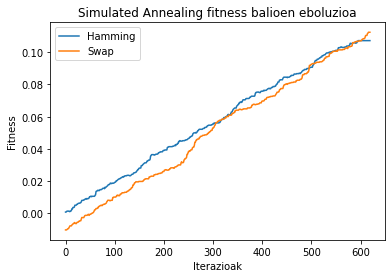

In [22]:
# create data
maxi = max(len(fitness_list_hamming), len(fitness_list_swap))
x = np.arange(maxi)

diff = len(fitness_list_hamming) - len(fitness_list_swap)
if diff>0:
  maxim = np.max(fitness_list_swap)
  fitness_list_swap.extend([maxim]*diff)
else:
  maxim = np.max(fitness_list_hamming)
  fitness_list_hamming.extend([maxim]*abs(diff))
  
# plot lines
plt.plot(x, fitness_list_hamming, label = "Hamming")
#plt.plot(x, fitness_list_insert[:mini], label = "Insert")
plt.plot(x, fitness_list_swap, label = "Swap")
plt.legend(loc = 'upper left')
plt.title("Simulated Annealing fitness balioen eboluzioa")
plt.xlabel("Iterazioak")
plt.ylabel("Fitness")
plt.show()

#Algoritmo poblazionala: Estimation of Distribution Algorithms (EDA)

In [23]:
#Emandako kopuru adina kide dituen populazioa sortzen du
def populazioa_sortu(populationSize):
  population = np.random.randint(0, k, (populationSize,n))
  
  return population

#Emandako kideari mutazio jakin bat aplikatzen dio (modua = 0 -> trukatu ausaz bi balio; modua = 1 -> aldatu kidearen balioen %20 ausaz)
def mutatu(kidea, modua =1, kop = None):
  berria = kidea
  if not kop:
    kop = int(len(kidea)/5)

  if modua==0: #Swap
    for _ in range(kop):
      lag = random.sample(range(len(kidea)),2) #Lortu ausazko 2 zenbaki ezberdin
      berria[lag[0]], berria[lag[1]] = berria[lag[1]], berria[lag[0]]

  elif modua==1: #random
    lag = random.sample(range(len(kidea)),kop) #Lortu kop adina ausazko zenbaki ezberdin
    for elem in lag:
      berria[elem] = random.randint(0,k-1)
  else:
    print("Mutatzeko modu zenbaki okerra")

  return berria 

#Emandako populazioaren banaketa probabilistikoa itzultzen du
def banaketa_prob(population):
    banaketa = np.zeros(shape=(n,k))
    for i in range(n):
        counts = np.unique(population[:,i],return_counts=True)
        banaketa[i][counts[0]] = counts[1]
    banaketa /= len(population)
    return banaketa

#Emandako banaketa probabilistikoa jarraituz soluzio berri bat sortzen du
def sortu_umea(banaketa):
  return np.asarray([np.random.choice(np.arange(k), p=banaketa[i]) for i in range(n)]) 


Eta azkenik, EDA algoritmoaren kodea:

In [24]:
#Estimation of Distribution Algorithms (EDA)
def EDA(G,max_iters, populationSize=20, numCross = 15, mutProb = 0.01, mutType = 1, mutSize = 500):
  """
  - param G: sarrerako grafoa
  - param max_iters: Zenbat aldiz eguneratuko den populazioa
  - param populationSize: Populazioan egongo diren soluzioen kopurua
  - param numCross: Iterazio bakoitzean zenbat soluzio berri sortuko diren
  - param mutProb: Soluzio berriak mutatzeko probabilitatea

  - return best_solution: Amaierako populazioko soluziorik onena
  - return best_fitness: Soluzio onenaren modularitate balioa
  """
  mutSize = min(mutSize, n//2)
  population = populazioa_sortu(populationSize)
  modularitateak = np.asarray([modularitatea(G,kide) for kide in population]) #Lortu populazioaren helburu-funtzioak
  modularity_evolution = np.empty((max_iters+1,populationSize))
  modularity_evolution[0][0] = np.max(modularitateak)
  modularity_evolution[0][1] = np.average(modularitateak)

  for i in range(max_iters): 
    banaketa = banaketa_prob(population) #Lortu populazioaren banaketa probabilistikoa

    for _ in range(numCross): 
        berria = sortu_umea(banaketa)
        if random.random()<mutProb: #Lagindu mutatzeko probabilitatea
          berria = mutatu(berria, mutType, mutSize)
        min_index = np.argmin(modularitateak) #Lortu modularitate balio minimoa duen soluzioaren indizea populazioan
        population[min_index] = berria #Ordezkatu soluzio txarrena berriarengatik
        modularitateak[min_index] = modularitatea(G,berria) #Eguneratu helburu-funtzioa

    modularity_evolution[i+1][0] = np.max(modularitateak)
    modularity_evolution[i+1][1] = np.average(modularitateak)

  max_index = np.argmax(modularitateak) #Lortu populazioko soluzio onenaren indizea
  best_solution = population[max_index]
  best_fitness = modularitateak[max_index]

  return best_solution, best_fitness,modularity_evolution

In [25]:
#1000*15 ebaluazio -> 0.179 fitness orig

EDAren errendimendua aztertzeko, iterazioro populazioko soluzioen fitness maximoa eta batazbestekoa gorde ditugu. Grafiko honetan ikus daitezke:

#Algoritmo eraikitzailea: GRASP

In [26]:
zentroa = "Pradeep K. Ravikumar"

#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  #aportazioak = np.where(solution[ii]==multzo,pisuak[berria,ii]-graduMul[berria,ii],0)
  aportazioak = np.where(solution[ii]==multzo,contributions[berria,ii],0)
  count = np.count_nonzero(aportazioak == 1)
  return np.sum(aportazioak)

def GRASP(G, greedy_prob=0.95, num_best_seeds = 20, num_onenak = 10):
  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  
  remaining = dict() #Hasieratu multzoa esleitzeko falta diren nodoen hiztegia
  for i in range(n):  
    remaining[i]=True 

  #aportazioak = pisuak-graduMul #Lortu aportazioen matrizea (modularitateko zati bat)
  aportazioak = contributions

  seeds = np.full(k-1,-1,dtype=np.int32) #Hasieratu seeds bektorea. Seed-ak komunitateko zentro bezala hartuko ditugu.

  first_seed = indizeak[zentroa] #Lehenengo komunitatearen seed-a grafoaren zentroa izango da
  solution[first_seed] = 0
  seeds[0] = first_seed
  remaining.pop(first_seed)

  for komunitate in range(1,k-1): #Lortu falta diren k-1 seed-ak

    Dj = np.amax(aportazioak[seeds[seeds>=0]], axis=0)
    Dj = np.tile(Dj, (n, 1)) #klonatu lerroak
    Cij= Dj-aportazioak
    Cij= np.where(Cij>0,Cij,0) #max(Cij,0) numpy estiloan

    baturak = Cij.sum(axis=0)
    baturak[seeds[seeds>-1]] = -1 #Ez utzi seed-ak errepikatzen. Aurretik hartuta daudenei -1 balioa jarri.

    onenak = np.argpartition(baturak, len(baturak) - num_best_seeds)[-num_best_seeds:] #itzuli num_onenak adina maximoren indizeak
    new_seed = random.choice(onenak) #Aukeratu ausaz seed bat onenen artean (GRASP erara)
    seeds[komunitate] = new_seed
    solution[new_seed] = komunitate

    remaining.pop(new_seed)

  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedy_prob: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) - num_onenak)[-num_onenak-1:-1] #itzuli num_onenak adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, modularitatea(G,solution), seeds


In [27]:
has = time()
best_solution, best_fitness, zentroak = GRASP(G,greedy_prob=0.95,num_onenak = 10)
buk = time()

# Azken emaitza:
print("Soluzio onena:",best_fitness,best_solution)
print("Banaketa:" , np.unique(best_solution,return_counts=True)[1])
print("Zentroak:" , zentroak)
print(f"Behar izandako denbora: {buk-has} s")

Soluzio onena: 0.7024578040347155 [4 4 4 ... 2 0 0]
Banaketa: [334 367 347 401 394]
Zentroak: [  78 1786 1656  697]
Behar izandako denbora: 0.8821980953216553 s


#Algoritmo eraikitzaile propioa

In [28]:
#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  #aportazioak = np.where(solution[ii]==multzo,pisuak[berria,ii]-graduMul[berria,ii],0)
  aportazioak = np.where(solution[ii]==multzo,contributions[berria, ii],0)
  return np.sum(aportazioak)

def inkrementala(G, greedyProb = 0.95, num_onenak = 4):
  """
  - param G: sarrerako grafoa
  - param greedyProb: Nodo bat aportazio maximoa ematen dion multzoan sartzeko probabilitatea (Greedy aukerarena)
  - param num_onenak: Greedy aukera hartu ezean onenetatik zenbat multzo kontsideratuko diren, horietatik ausaz hartzeko (GRASP bezala)

  - return solution: Eraikitako soluzioa
  - return zentroak: Multzo bakoitzaren zentroa (hasieran zegoen nodoa)
  """

  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  remaining = list(range(n)) #Hasieratu multzoa esleitzeko falta diren nodoen lista
  zentroak = random.sample(range(n), k) #Hartu ausazko k zentru
  zentroak.sort(reverse=True) #Ordenatu zentroak handitik txikira

  for i in range(k): #Zentro bakoitzeko
    remaining.pop(zentroak[i]) #Kendu zentroa remaining listatik
    solution[zentroak[i]]=i #Esleitu multzoa zentroari
  
  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedyProb: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) - num_onenak)[-num_onenak-1:-1] #itzuli num_onenak adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, zentroak
  #aportazioak = np.where(autistak[ii]>0 and pisuak[autistak[ii],jj]-graduMul[autistak[ii],jj]>threshold,ii,-1)

solution, zentroak = inkrementala(G)
modularitatea(G,solution)



0.6881620421176712

#Probak

In [ ]:
# simulated_annealing(G,max_evals,has_prob=0.8,buk_prob=0.01,tries=50, ingurune_func = "hamming", greedy = False)
# (fitness,sol,evals, fitness_list_hamming) = simulated_annealing(G,max_evals, tries =5000, ingurune_func = "hamming", has_prob = 0.5, buk_prob = 0.01, greedy = False)

In [ ]:
#Simulated Annealing parameters
maxEvalsG = [100000]
has_probG = [0.99, 0.9, 0.7]
triesG = [1000,10000]
greedyG = [True, False]
ingurune_funcG = ["swap"]
#ingurune_funcG = ["swap"]

In [ ]:
import csv
k=5

with open(directory+"data/SA/probakSA" + ingurune_funcG[0] + ".csv", 'w') as f:
    writer = csv.writer(f)
    #gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
    row= ["Instantzia","Algoritmoa", "Ingurunea", "Evals", "Fitness", "Denbora(s)", "hasProb", "tries", "maxEvals", "greedy"]
    # write a row to the csv file
    writer.writerow(row)
    for instance in ["ins100","ins200","ins400","ins1000","insOrig"]:
      G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
      n = G.number_of_nodes()
      for ing in ingurune_funcG:
        print(ing)
        for maxEvals in maxEvalsG:
          print(str(maxEvals))
          for hasProb in has_probG:
            print(hasProb)
            for saiakera in triesG:
              print(saiakera)
              for boo in greedyG:
                  flista = []
                  dlista = []
                  for _ in range(1):
                    has = time()
                    (fitness,sol,evals, fitness_list) = simulated_annealing(G,maxEvals, tries = saiakera, ingurune_func = ing, has_prob = hasProb, buk_prob = 0.001, greedy = boo)
                    denb = time() - has
                    flista.append(fitness)
                    dlista.append(denb)
                  row= [instance,"SA", ing, evals, np.mean(flista), np.mean(dlista), hasProb, saiakera, 100000, boo]
                  # write a row to the csv file
                  writer.writerow(row)

swap
100000
0.99
1000
10000
0.9
1000
10000
0.7
1000
10000
swap
100000
0.99
1000
10000
0.9
1000
10000
0.7
1000
10000
swap
100000
0.99
1000
10000
0.9
1000
10000
0.7
1000
10000
swap
100000
0.99
1000
10000
0.9
1000
10000
0.7
1000
10000
swap
100000
0.99
1000
10000
0.9
1000
10000
0.7
1000
10000


In [ ]:

# for ing in ingurune_funcG:
#   print(ing)
#   for maxEvals in maxEvalsG:
#     print(str(maxEvals))
#     for hasProb in has_probG:
#       for saiakera in triesG:
#         for boo in greedyG:
#           path = directory + "data/SA_" + ing + "/evals" + str(maxEvals) + "/" + ing + str(hasProb) + str(saiakera) + str(boo)
#           outfile = open(path,'wb')
#           has = time()
#           (fitness,sol,evals, fitness_list) = simulated_annealing(G,maxEvals, tries = saiakera, ingurune_func = ing, has_prob = hasProb, buk_prob = 0.001, greedy = boo)
#           buk = time() - has
#           #gorde = {"best_fitness": fitness, "best_solution":sol, "fit_evolution": fitness_list, "denbora": buk}
#           gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
#           pickle.dump(gorde, outfile)
#           outfile.close()

In [ ]:
# 1000000/swap/0.99/10/True
# maxEvals = 1000000
# path = directory + "data/SA_" + ing + "/evals" + str(maxEvals) + "/" + ing + str(hasProb) + str(saiakera) + str(boo)
# infile = open(path,'rb')
# datuak = pickle.load(infile) # datuak aldagaiaren egitura: {"best_fitness": fitness, "best_solution":sol, "fit_evolution": fitness_list, "denbora": denb}
# #Hemen datuekin egin nahi duzuna
# infile.close()

In [ ]:
# maxEvalsG = [10**i for i in range(3, 6)]
# has_probG = [0.99, 0.95, 0.9, 0.8, 0.6, 0.4, 0.2, 0.05, 0.01, 0.001]
# triesG = [10,20,50,100,300,500,1000,5000,10000]
# greedyG = [True, False]
# best_fitness1  = 0
# params1 = 0
# best_fitness2 = 0
# params2 = 0
# best_fitness3 = 0
# params3 = 0
# #ingurune_funcG = ["hamming", "swap"]
# #ingurune_funcG = ["hamming"]
# ingurune_funcG = ["swap"]
# for ing in ingurune_funcG:
#   for maxEvals in maxEvalsG:
#     for hasProb in has_probG:
#       for saiakera in triesG:
#         for boo in greedyG:
#           #print(str(maxEvals) + "/" + ing + "/" +  str(hasProb) + "/" +  str(saiakera) + "/" +  str(boo))
#           path = directory + "data/original/SA_" + ing + "/evals" + str(maxEvals) + "/" + ing + str(hasProb) + str(saiakera) + str(boo)
#           infile = open(path,'rb')
#           datuak = pickle.load(infile) # datuak aldagaiaren egitura: {"best_fitness": fitness, "best_solution":sol, "fit_evolution": fitness_list, "denbora": denb}
#           #print(datuak["params"])
#           #Hemen datuekin egin nahi duzuna
#           if maxEvals == 1000:
#             if best_fitness1<datuak["best_fitness"]:
#               best_fitness1 = datuak["best_fitness"]
#               params1 = datuak["params"]
#           if maxEvals == 10000:
#             if best_fitness2<datuak["best_fitness"]:
#               best_fitness2 = datuak["best_fitness"]
#               params2 = datuak["params"]
#           if maxEvals == 100000:
#             if best_fitness3<datuak["best_fitness"]:
#               best_fitness3 = datuak["best_fitness"]
#               params3 = datuak["params"]
#           infile.close()

In [ ]:
# print(best_fitness1, params1)
# print(best_fitness2, params2)
# print(best_fitness3, params3)

0.1414931296197681 {'ing': 'swap', 'maxEvals': 1000, 'hasProb': 0.2, 'tries': 50, 'greedy': True}
0.5012100355638971 {'ing': 'swap', 'maxEvals': 10000, 'hasProb': 0.01, 'tries': 100, 'greedy': False}
0.7330516972697956 {'ing': 'swap', 'maxEvals': 100000, 'hasProb': 0.001, 'tries': 1000, 'greedy': False}


In [ ]:
#Parametro hoberenak gorde SA
# print(best_fitness1, params1)
# print(best_fitness2, params2)
# print(best_fitness3, params3)
# hoberenak = [(best_fitness1, params1), (best_fitness2, params2), (best_fitness3, params3)]
# for hoberena in hoberenak:
#   path = directory + "data/SA_" + hoberena[1]["ing"] + "/evals" + str(hoberena[1]["maxEvals"]) + "/" + hoberena[1]["ing"] + str(hoberena[1]["hasProb"]) + str(hoberena[1]["tries"]) + str(hoberena[1]["greedy"])
#   infile = open(path,'rb')
#   datuak = pickle.load(infile)
#   infile.close()
#   path = directory + "data/SA_" + hoberena[1]["ing"] + "/best_" + hoberena[1]["ing"] + str(hoberena[1]["maxEvals"])
#   outfile = open(path,'wb')
#   pickle.dump(datuak, outfile)
#   outfile.close()

0.13278542569943586 {'ing': 'hamming', 'maxEvals': 1000, 'hasProb': 0.2, 'tries': 500, 'greedy': False}
0.5738104940142212 {'ing': 'hamming', 'maxEvals': 10000, 'hasProb': 0.6, 'tries': 10000, 'greedy': True}
0.7139152210149704 {'ing': 'hamming', 'maxEvals': 100000, 'hasProb': 0.9, 'tries': 10000, 'greedy': True}


In [ ]:
# path = directory + "data/SA_hamming/best_hamming1000"
# infile = open(path,'rb')
# datuak = pickle.load(infile)
# print(datuak["params"])
# infile.close()

{'ing': 'hamming', 'maxEvals': 1000, 'hasProb': 0.2, 'tries': 500, 'greedy': False}


In [ ]:
#ingurunetik hoberena lortzeko
# best_fitness = 0
# path = directory + "data/SA_swap/best_hamming"
# for hoberena in hoberenak:
#   has = time()
#   (fitness,sol,evals, fitness_list) = simulated_annealing(G, 1000000, tries = hoberena[1]["tries"], ingurune_func = hoberena[1]["ing"], has_prob = hoberena[1]["hasProb"], buk_prob = 0.001, greedy = hoberena[1]["greedy"])
#   buk = time() - has
#   print(fitness)
#   if best_fitness<fitness:
#     best_fitness = fitness
#     print(hoberena[1])
#     outfile = open(path, "wb")
#     gorde = {"best_fitness": fitness, "best_solution":sol, "fit_evolution": fitness_list, "denbora": buk, "params": hoberena[1]}
#     pickle.dump(gorde, outfile)
#     outfile.close()


0.7179068427895161
{'ing': 'hamming', 'maxEvals': 1000, 'hasProb': 0.2, 'tries': 500, 'greedy': False}
0.717559548035471
0.7224941655788873
{'ing': 'hamming', 'maxEvals': 100000, 'hasProb': 0.9, 'tries': 10000, 'greedy': True}


In [ ]:
# print(best_fitness)

0.7224941655788873


In [42]:
#EDA parameters
populationSizeG = [20, 40, 100]
populationSizeG = [10, 15, 20, 25,30]
numCrossG = [5,10,15,20,25]#[5, 20 , 25] #10,15
mut_probG = [0.01]
mutTypeG = [1]
mutSizeG = [500]

In [44]:
import csv

modua = "w"
with open(directory+'data/EDA/probak2.csv', modua) as f:
    writer = csv.writer(f)
    if modua == "w":
      row= ["Instantzia","Algoritmoa","Evals","Fitness", "Denbora(s)", "PopSize", "NumCross", "mutProb", "mutType", "mutSize"]
      # write a row to the csv file
      writer.writerow(row)
    for instance in ["ins100","ins200","ins400","ins1000","insOrig"]:
        G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj , zentroa= pickle.load(open(directory+"/data/"+instance, "rb")) 
        n = G.number_of_nodes()
        for pop in populationSizeG:
          print("Populazioa: ",pop)
          for num_cross in numCrossG:
            print("Num cross: ",num_cross)
            if True:
              for mut_prob in mut_probG:
                for mut_type in mutTypeG:
                  for mut_size in mutSizeG:
                    flista = []
                    dlista = []
                    print("mut_size: ", mut_size)
                    for _ in range(1):
                      has = time()
                      best_solution, best_fitness, mod_evolution = EDA(G,600//num_cross, populationSize=pop, numCross = num_cross, mutProb = mut_prob, mutType = mut_type, mutSize = mut_size)
                      denb = time() - has
                      flista.append(best_fitness)
                      dlista.append(denb)
                    row= [instance,"EDA",5*num_cross,np.mean(flista),np.mean(dlista),pop,num_cross,mut_prob,mut_type,mut_size]
                    # write a row to the csv file
                    writer.writerow(row)

Populazioa:  10
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa:  15
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa:  20
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa:  25
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa:  30
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa:  10
Num cross:  5
mut_size:  500
Num cross:  10
mut_size:  500
Num cross:  15
mut_size:  500
Num cross:  20
mut_size:  500
Num cross:  25
mut_size:  500
Populazioa

In [ ]:
import csv
#GRASP
greedy_probG = [0.95, 0.9, 0.8]
num_onenakG = [4,10,20]
num_best_seedsG = [4,10,20]
k=21

with open(directory+'data/GRASP/probakGRASP.csv', 'w') as f:
    writer = csv.writer(f)
    #gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
    row= ["Instantzia","Algoritmoa", "Evals", "Fitness", "Denbora(s)", "greedyProb", "numOnenak", "num_best_seeds"]
    # write a row to the csv file
    writer.writerow(row)
    for instance in ["ins100","ins200","ins400","ins1000","insOrig"]:
      G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
      n = G.number_of_nodes()
      for greedyProb in greedy_probG:
        for numOnenak in num_onenakG:
          for num_best_seeds in num_best_seedsG:
            flista=[]
            dlista=[]
            for _ in range(1):
              has = time()
              best_solution, best_fitness, zentroak = GRASP(G,greedy_prob=greedyProb,num_onenak = numOnenak, num_best_seeds= num_best_seeds)
              denb = time() - has
              flista.append(best_fitness)
              dlista.append(denb)
            row= [instance,"GRASP", 1, np.mean(flista), np.mean(dlista), greedyProb, numOnenak, num_best_seeds]
            # write a row to the csv file
            writer.writerow(row)

In [ ]:
import csv

greedy_probG = [0.95, 0.9, 0.8]
num_onenakG = [4,10,20]
#Eraikitzailea
with open(directory+'data/Eraikitzailea/probakEraikitzailea.csv', 'w') as f:
    writer = csv.writer(f)
    #gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
    row= ["Instantzia","Algoritmoa", "Evals", "Fitness", "Denbora(s)", "greedyProb", "numOnenak"]
    # write a row to the csv file
    writer.writerow(row)
    for instance in ["ins100","ins200","ins400","ins1000","insOrig"]:
      G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
      n = G.number_of_nodes()
      for greedyProb in greedy_probG:
        for numOnenak in num_onenakG:
          flista=[]
          dlista=[]
          for _ in range(3):
            has = time()
            solution, zentroak = inkrementala(G, greedyProb = greedyProb, num_onenak = numOnenak)
            fitness = modularitatea(G,solution)
            denb = time() - has
            flista.append(fitness)
            dlista.append(denb)
          row= [instance,"Eraikitzailea", 1, np.mean(flista), np.mean(dlista), greedyProb, numOnenak]
          # write a row to the csv file
          writer.writerow(row)

In [ ]:
def param_hoberenak_lortu(alg_izena, hamming=False, params = True):
  if alg_izena.lower() == "sa":
    if hamming:
      path = directory + "data/SA_swap/best_hamming"
    else:
      path = directory + "data/SA_swap/best_swap"
  elif alg_izena.lower() == "eda":
    path = directory + "data/eda/best_eda"
  elif alg_izena.lower() == "eraikitzailea":
    path = directory + "data/best_eraikitzailea"
  elif alg_izena.lower() == "grasp":
    path = directory + "data/best_grasp"
  infile = open(path,'rb')
  datuak = pickle.load(infile)
  infile.close()
  if params:
    return datuak["params"]
  return datuak


In [ ]:
irt_pisuak = []
nodoak = list(G.nodes)
for i in range(len(nodoak)):
    pisua = 0 
    for k, v in G[nodoak[i]].items():
        pisua += v["weight"]
    irt_pisuak.append(pisua)

In [ ]:
import random
def generatorv2(G, nodoak, v, irt_pisuak):
  #nodoak = np.array(list(G.nodes))
  prob = np.asarray([G.degree(nodoak[i])+irt_pisuak[i] for i in range(len(nodoak))], dtype = float)
  prob/=np.sum(prob)
  num_nodes = G.number_of_nodes()
  aukeratuak = np.random.choice(range(num_nodes), p = prob, replace = False, size=v)
  subGrafo = G.subgraph(nodoak[aukeratuak])
  return subGrafo

In [ ]:
izenak = ["ins100", "ins200", "ins400", "ins1000", "insOrig"]
nk= [100, 200, 400, 1000, 1843]
for i in range(len(izenak)):
  subGr = generatorv2(G, nodoak, nk[i], irt_pisuak)
  path = directory + "data/" + izenak[i]
  outfile = open(path, "wb")
  pickle.dump(subGr, outfile)
  outfile.close()

TypeError: ignored

In [ ]:
path = directory + "data/" 
outfile = open(path, "wb")
lista = []
for i in range(100):
  best_solution, best_fitness, zentroak = GRASP(G)
  lista
pickle.dump(subGr, outfile)
outfile.close()